In [8]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

import brisque

# Image quality assessment

Testing the BRISQUE (blind/referenceless image spatial qualityevaluator) method for image quality evaluation. The method is based on the paper, 

Mittal, A., Moorthy, A. K., & Bovik, A. C. (2012). No-reference image quality assessment in the spatial domain. IEEE Transactions on Image Processing, 21(12), 4695-4708.

The implementation refers to https://github.com/ocampor/notebooks/blob/master/notebooks/image/quality/brisque.ipynb. The method assumes locally normalized luminance coefficients of a good quality natural image follows a certain distribution. If it's violated, the image is more likely to be **blurred, noisy, or heavily compressed** (low quality). Alternatively, for example, blurriness may be assessed through transformations to spatial frequency space or with discrete cosine bases. 

To show how the method would work, we first load a testing image: 

In [6]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')


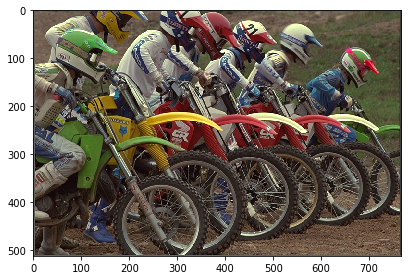

In [158]:
plt.figure(figsize=(6, 4)) 

url = 'http://www.cs.albany.edu/~xypan/research/img/Kodak/kodim05.png'
image = load_image(url)
gray_image = skimage.color.rgb2gray(image)

_ = skimage.io.imshow(image)

## Calculate the mean substracted contrast normalized (MSCN) coefficients

In [159]:
kernel = brisque.gaussian_kernel2d(n=10, sigma=7/6)
local_mean = signal.convolve2d(gray_image, kernel, 'same')
local_var = brisque.local_deviation(gray_image, local_mean, kernel)

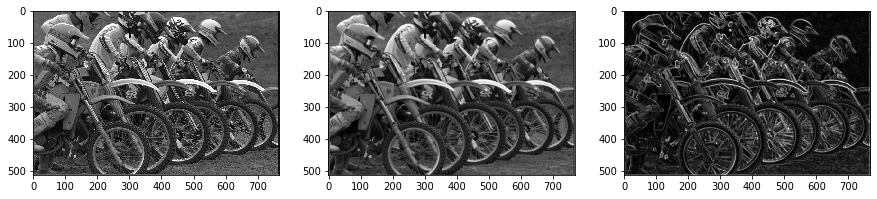

In [160]:
plt.figure(figsize=(15, 6))
plt.subplot(131); plt.imshow(gray_image, cmap='gray')
plt.subplot(132); plt.imshow(local_mean, cmap='gray')
plt.subplot(133); plt.imshow(local_var, cmap='gray')

In [161]:
mscn_coefficients = brisque.calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = brisque.calculate_pair_product_coefficients(mscn_coefficients)

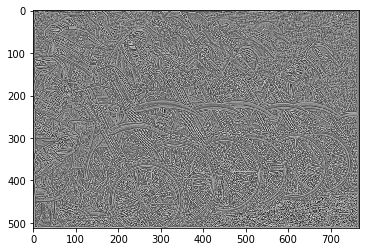

In [162]:
plt.figure(figsize=(6, 4)) 
plt.imshow(mscn_coefficients, cmap='gray')

In [41]:
coefficients.keys()

odict_keys(['mscn', 'horizontal', 'vertical', 'main_diagonal', 'secondary_diagonal'])

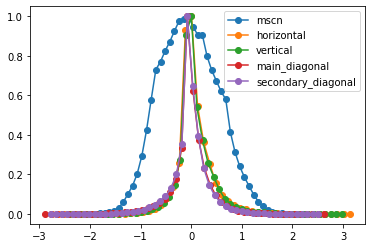

In [163]:
for label, x in coefficients.items():
    plot_histogram(x, label=label)
plt.legend()

## Calculate the feature vector 
which includes fitted parameters for the generalized gaussian distributions (GGD) and asymmetric GGD 

In [164]:
brisque_features = brisque.calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)
brisque_features.shape

(18,)

## Use an off-the-shelf classifier for image quality assessment
https://github.com/ocampor/image-quality/blob/master/imquality/models/brisque_svm.txt

The feature-score mapping (the regressor SVR maps from the vector with features to an subjective quality score) was trained based on, *TID2008 – A database for evaluation of full-reference visual quality assessment metrics*,
http://ponomarenko.info/papers/mre2009tid.pdf

In [165]:
# concatenate features from a scaled down image, and  then normalize the feature vector
downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = brisque.calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

In [166]:
# normalize brisque_features to match the range used for training
with open('normalize.pickle', 'rb') as handle:
    scale_params = pickle.load(handle)

min_ = np.array(scale_params['min_'])
max_ = np.array(scale_params['max_'])

scaled_brisque_features = -1 + (2.0 / (max_ - min_) * (brisque_features - min_))

In [167]:
model = svmutil.svm_load_model('brisque_svm.txt')

x, idx = svmutil.gen_svm_nodearray(
    scaled_brisque_features,
    isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))

nr_classifier = 1
prob_estimates = (svmutil.c_double * nr_classifier)()

print(svmutil.libsvm.svm_predict_probability(model, x, prob_estimates))

4.954157281562374


##### As a function

In [71]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))


def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)


In [168]:
calculate_image_quality_score(brisque_features)

4.954157281562374

The scaled used to represent image quality goes from 0 to 100. An image quality of 100 means that the image's quality is very bad. 

## Test a few more images

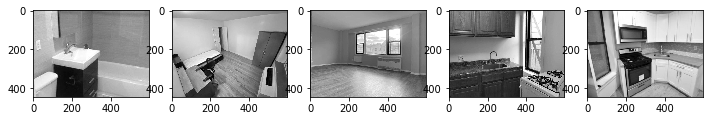

In [147]:
kernel_size = 10

mscn_test = {}
brisque_features_test = {}
plt.figure(figsize=(12,3))

for img_ind in range(5): 
    # load gray images
    image = skimage.io.imread('test0' + str(img_ind) + '.jpg')
    gray_image = skimage.color.rgb2gray(image)
    plt.subplot(1,5,img_ind+1) 
    plt.imshow(gray_image, cmap='gray')
    
    # calculate mscn coefficient
    mscn_tmp = brisque.calculate_mscn_coefficients(gray_image, kernel_size, 7/6)
    mscn_test['img'+str(img_ind)] = brisque.calculate_pair_product_coefficients(mscn_tmp)
    
    # get the feature vector
    brisque_features = brisque.calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)
    downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    downscale_brisque_features = brisque.calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

    brisque_features_test['img'+str(img_ind)] = np.concatenate((brisque_features, downscale_brisque_features))

In [148]:
# calculate the quality score
brisque_score = {}
for label, brisque_features in brisque_features_test.items():
    brisque_score[label] = calculate_image_quality_score(brisque_features)

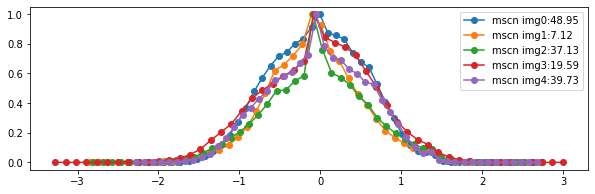

In [149]:
plt.figure(figsize=(10, 3))
for label, x in mscn_test.items():
    plot_histogram(x['mscn'], label='mscn '+label+':'+str(np.round(brisque_score[label],2)))
plt.legend(); 

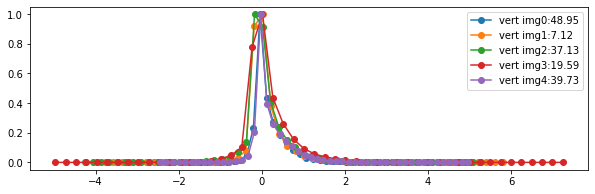

In [150]:
plt.figure(figsize=(10, 3))
for label, x in mscn_test.items():
    plot_histogram(x['vertical'], label='vert '+label+':'+str(np.round(brisque_score[label],2)))
plt.legend(); 

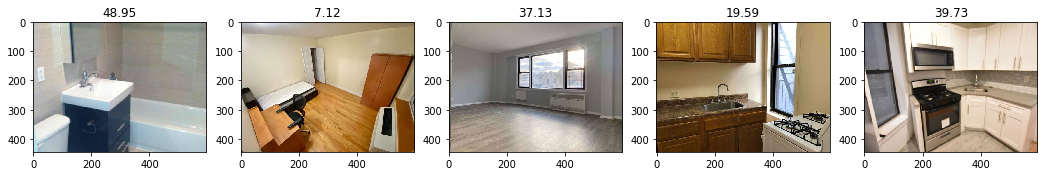

In [151]:
plt.figure(figsize=(18,9))
for img_ind in range(5): 
    # load gray images
    image = skimage.io.imread('test0' + str(img_ind) + '.jpg')
    plt.subplot(1,5,img_ind+1)
    plt.imshow(image)
    plt.title(np.round(brisque_score['img'+str(img_ind)], 2))

img0 and img4 are blurred images. img2 has overexposure, which may impact the quality?

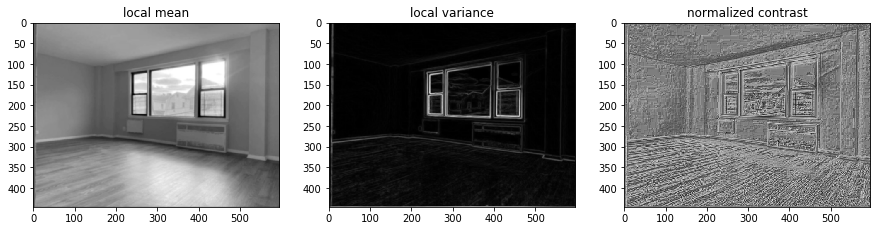

In [155]:
img_ind = 2
image = skimage.io.imread('test0' + str(img_ind) + '.jpg')
gray_image = skimage.color.rgb2gray(image)
local_mean = signal.convolve2d(gray_image, kernel, 'same')
local_var = brisque.local_deviation(gray_image, local_mean, kernel)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(local_mean, cmap='gray'); plt.title('local mean'); 
plt.subplot(132)
plt.imshow(local_var, cmap='gray'); plt.title('local variance'); 
plt.subplot(133)
plt.imshow(mscn_test['img'+str(img_ind)]['mscn'], cmap='gray'); plt.title('normalized contrast'); 